# Teste Avaliativo - Estágio em Engenharia/Análise de Dados

## Descrição
Este projeto contém uma análise quantitativa e qualitativa dos dados extraídos da API pública de contratos do Instituto de Pesquisa Econômica Aplicada (Ipea).

In [375]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns

In [376]:
url = "https://contratos.comprasnet.gov.br/api/contrato/ug/113601"
response = requests.get(url)
data = response.json()
df = pd.DataFrame(data)

## Análise Quantitativa

Nessa etapa, serão realizadas as métricas descritivas dos principais indicadores, como:

- Média
- Desvio-Padrão
- Distribuição dos dados    

In [377]:
#Converte para um valor numérico algumas colunas que estão representadas como string
collums_to_number = [
    "valor_inicial",
    "valor_global",
    "valor_parcela",
    "valor_acumulado"
]


#Normalização de valores para os padrões de representação numérica ingleses.
for col in collums_to_number:
    df[col] = df[col].apply(lambda value: float(value.replace('.', '').replace(',', '.')))            
df["num_parcelas"] = df["num_parcelas"].astype(int)
descriptive_stats = df[collums_to_number].describe()

total_global = df["valor_global"].sum()
total_spent = df["valor_acumulado"].sum()

#Número total de contratos feitos
total_contracts = df["id"].count();


# Adiciona o campo "nome" no dataframe
df_fornecedor = pd.json_normalize(df["fornecedor"])
df = pd.concat([df, df_fornecedor], axis=1)


mean_valor = df["valor_global"].mean()
std_valor = df["valor_global"].std()

# Contratos acima de 2 desvios padrão
contratos_outliers = df[df["valor_global"] > mean_valor + 2 * std_valor]
total_outliers = contratos_outliers.shape[0]


df["cnpj_cpf_idgener"] = df["fornecedor"].apply(lambda x: x.get("cnpj_cpf_idgener") if isinstance(x, dict) else None)
df["nome_fornecedor"] = df["fornecedor"].apply(lambda x: x.get("nome") if isinstance(x, dict) else None)


# Contar contratos por CNPJ do fornecedor
fornecedores_contratos = df.groupby("cnpj_cpf_idgener").size().reset_index(name="quantidade_contratos")
# Ordenar em ordem decrescente para facilitar a análise
fornecedores_contratos = fornecedores_contratos.sort_values(by="quantidade_contratos", ascending=False)

# Filtrar fornecedores com 2 ou mais contratos
fornecedores_multicontratos = fornecedores_contratos[fornecedores_contratos["quantidade_contratos"] > 1]
total_fornecedores_multicontratos = fornecedores_multicontratos.shape[0]

cnpjs_outliers = set(contratos_outliers["cnpj_cpf_idgener"])
cnpjs_multicontratos = set(fornecedores_multicontratos["cnpj_cpf_idgener"])

# Interseção dos CNPJs com Outliers
cnpjs_relacionados = cnpjs_outliers.intersection(cnpjs_multicontratos)
total_outliers_multicontratos = len(cnpjs_relacionados)


empresas_relacionadas = df[df["cnpj_cpf_idgener"].isin(cnpjs_relacionados)]
empresas_relacionadas_info = empresas_relacionadas[["cnpj_cpf_idgener", "nome_fornecedor", "id", "valor_global"]]


# Análise de Contratos Outliers

Por meio da análise dos contratos registrados no IPEA, foi revelado um grupo de contratos com valores iniciais significamente elevados, classificados como **outliers**. Esses contratos se destacam por estarem acima de 2 desvios padrão da média dos valores iniciais registrados, indicando situações atípicas e/ou contratos de maior relevância financeira.




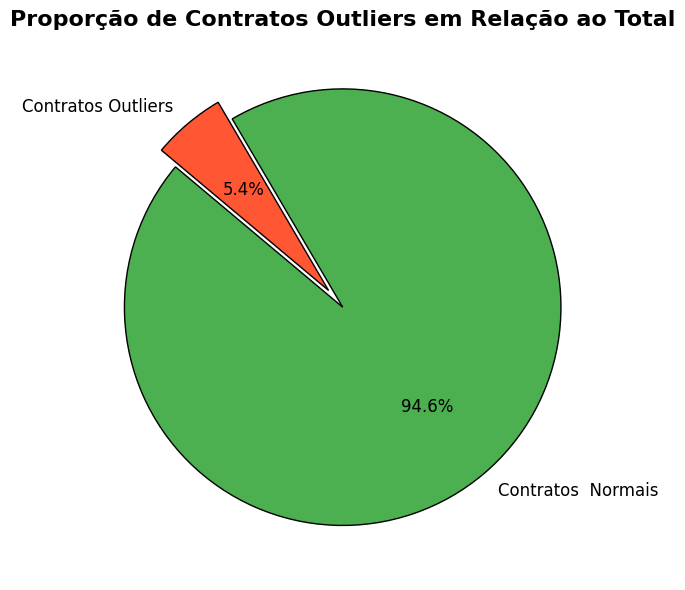

In [378]:



# Dados para o gráfico
labels = ["Contratos  Normais", "Contratos Outliers"]
sizes = [total_contracts - total_outliers, total_outliers]
colors = ["#4CAF50", "#FF5733"]  
explode = (0, 0.1)  # Destacar a fatia dos outliers

plt.figure(figsize=(8, 6))
plt.pie(
    sizes,
    labels=labels,
    colors=colors,
    autopct="%1.1f%%",
    explode=explode,
    startangle=140,
    wedgeprops={"edgecolor": "black"}, 
    textprops={"fontsize": 12},  
)
plt.title("Proporção de Contratos Outliers em Relação ao Total", fontsize=16, weight="bold")
plt.tight_layout()
plt.show()



O gráfico de pizza apresentado ilustra a proporção entre o total de contratos registrados pelo IPEA e os contratos classificados como outliers. Apesar de os contratos outliers representarem uma pequena parcela do total, sua identificação é significativa devido às suas características atípicas, como valores globais acima de 2 desvios padrão da média.

Além disso, destaca-se que, entre os contratos classificados como outliers, 2 deles estão associados a fornecedores que possuem **mais de um contrato com o IPEA**. Essa relação reforça a importância de uma análise detalhada sobre os fornecedores e os contratos, pois pode indicar:
 - Favorecimento de fornecedores específicos
 - Dependência de fornecedores

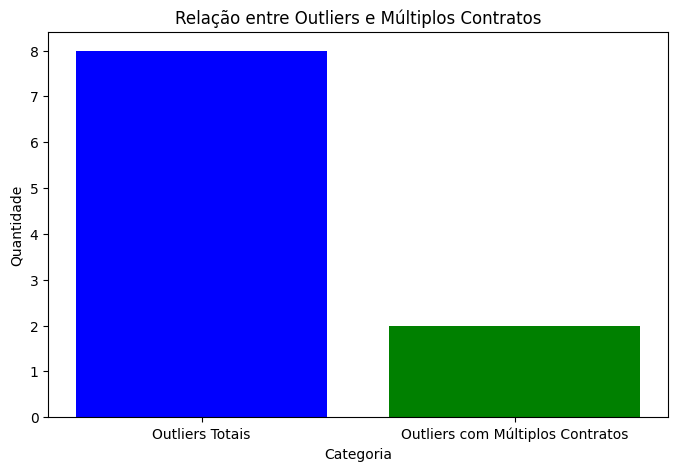

In [379]:
# Valores para o gráfico

# Dados categorizados
categorias = ['Outliers Totais', 'Outliers com Múltiplos Contratos']
valores = [total_outliers, total_outliers_multicontratos]

# Gerar gráfico de barras
plt.figure(figsize=(8, 5))
plt.bar(categorias, valores, color=['blue', 'green'])
plt.title('Relação entre Outliers e Múltiplos Contratos')
plt.ylabel('Quantidade')
plt.xlabel('Categoria')
plt.show()

In [380]:
sum_outliers_values = round(contratos_outliers["valor_global"].sum(), 2)
print(sum_outliers_values)
print(total_global)

37500180.4
61747692.3


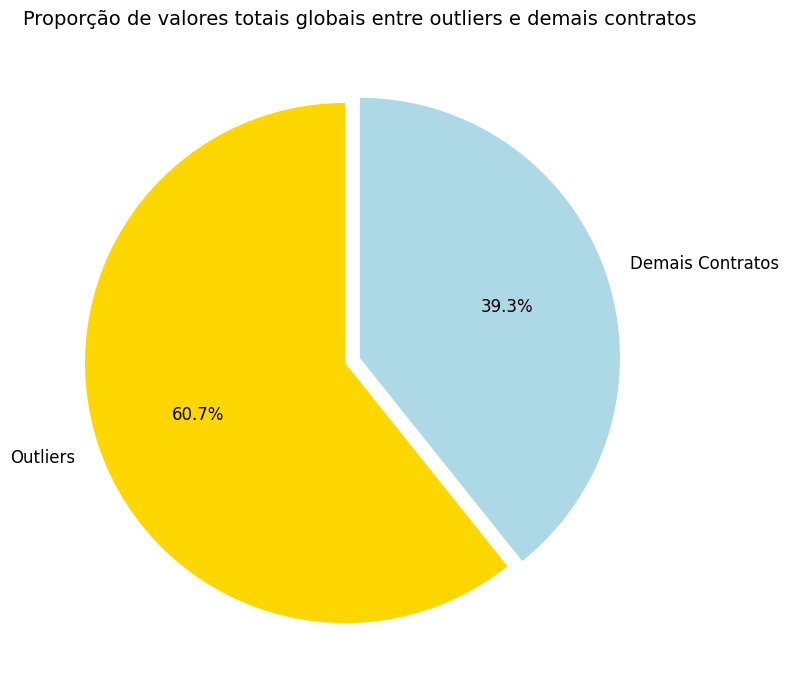

In [381]:
# Dados para o gráfico
categorias = ["Outliers", "Demais Contratos"]
valores = [sum_outliers_values, total_global - sum_outliers_values]

# Criar gráfico de pizza
plt.figure(figsize=(8, 8))
colors = ["gold", "lightblue"]
explode = (0.06, 0)  # Destacar a fatia dos outliers
plt.pie(
    valores,
    labels=categorias,
    autopct="%1.1f%%",
    startangle=90,
    colors=colors,
    explode=explode,
    textprops={"fontsize": 12}
)

plt.title("Proporção de valores totais globais entre outliers e demais contratos", fontsize=14)

plt.tight_layout()
plt.show()

Essa análise revelou que uma pequena porção de fornecedores, classificados como **outliers**, representam mais de 60% do valor total global dos contratos. Com essa descoberta é possível concluir que:

- Apenas uma fração dos contratos absorve a maior parte dos recursos financeiros disponíveis, indicando uma concentração significativa em contratos de alto valor. Desse modo, é crucial que haja uma análise detalhada desses contratos, pois possuem impacto direto e significativo no orçamento total.

- Qualquer inconsistência, atraso ou falhas envolvendo esses contratos pode ocasionar em graves consequências financeiras e operacionais.

- Alguns desses outliers possuem multiplos contratos, o que pode indicar certa dependência ou favoritismo em relação a determinados fornecedores, diminuindo a competitividade e diversificação na contratação de serviços.

Para uma análise mais detalhada é preciso aplicar outras métricas e fazer uma análise minuciosa dos outliers envolvidos.